In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
from PIL import Image 
import pywt

(CVXPY) Apr 11 10:47:38 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 11 10:47:38 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
# Defining code to test metrics
def mse(image1, image2):
    squared_diff = (image1 - image2) ** 2
    mse = squared_diff.mean()
    return mse
def mad(image1, image2):
  diff = image1 - image2
  return np.mean(abs(diff))

In [3]:
X_full = mpl.pyplot.imread('face.jpeg') #loading image
X_full = X_full.mean(axis=2) #changing it to "grayscale"
X = spimg.zoom(X_full, 0.15) #downsizing image, 0.15 was largest before
height,width = X.shape #getting height and width of image

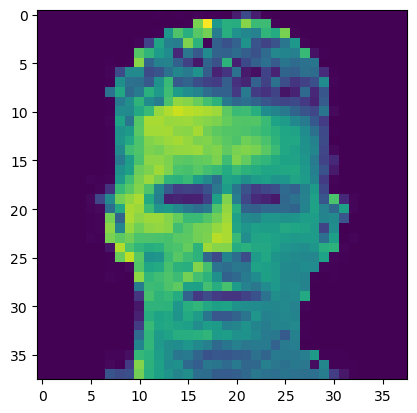

In [4]:
plt.imshow(X)

In [5]:
Y = pywt.dwt2(X, 'db1') #taking Wavelet

In [6]:
cA, (cH, cV, cD) = Y
len(cD)

19

In [7]:
# Using parts of wavelet transform to create image vector
Y = np.block([
    [cA,cH],
    [cV,cD]
])

In [8]:
y = np.array(Y)

In [9]:
width, height = Y.shape

In [10]:
y = Y.flatten()

In [11]:
dim = y.size

In [12]:
# creating sensing matrix
A = np.random.randint(0,2,size=(dim//2,dim))

In [13]:
b = A@y

In [14]:
# Optimization on real part
ysparsereal = cvx.Variable(dim)
obj = cvx.Minimize(cvx.norm(ysparsereal, 1))
constraints = [cvx.norm(A@ysparsereal - b.real,2) <= 1e-8]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

/Users/Divya/anaconda3/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [15]:
# Optimization on imaginary part
ysparseimag = cvx.Variable(dim)
obj = cvx.Minimize(cvx.norm(ysparseimag, 1))
constraints = [cvx.norm(A@ysparseimag - b.imag,2) <= 1e-8]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

In [16]:
ysparse = ysparsereal.value + ysparseimag.value*1j #Joining real and imaginary to make final result

In [17]:
Ysparse = ysparse.reshape((width,height))

(<matplotlib.image.AxesImage at 0x1263ce9d0>,
 <matplotlib.colorbar.Colorbar at 0x1248ca010>)

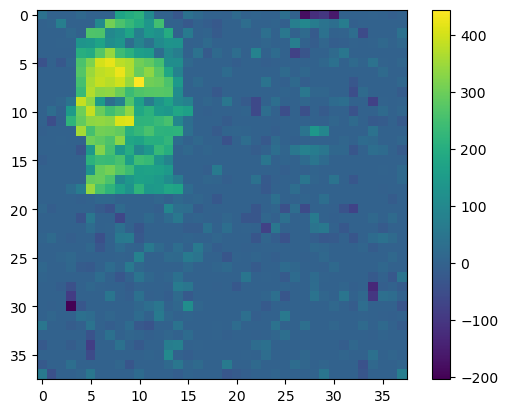

In [18]:
plt.imshow(Ysparse.real), plt.colorbar()

In [19]:
np.count_nonzero(Ysparse.real.round(8))

1404

In [20]:
#Choosing sections of wavelet transform to keep formatting the same
LL = Ysparse[:(width//2), :(height//2)]
HL = Ysparse[:(width//2), -(height//2):]
LH = Ysparse[-(width//2):, :(height//2)]
HH = Ysparse[-(width//2):, -(height//2):]

In [21]:
coeffs = (LL, (HL, LH, HH))

In [22]:
# Reconstructing
Xhat = pywt.idwt2(coeffs, 'db1').real

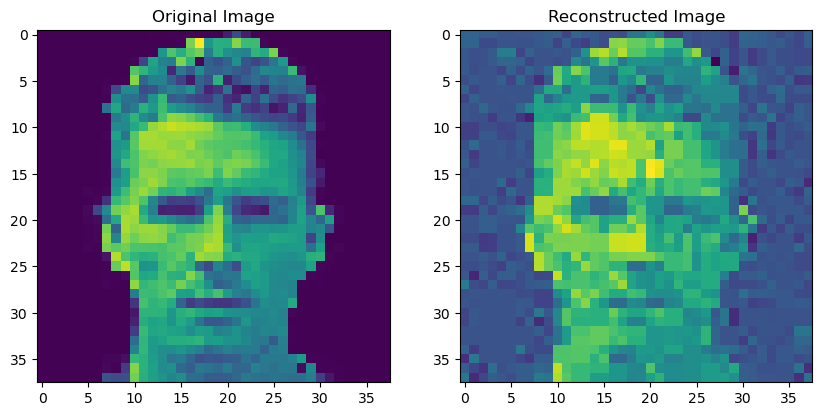

In [23]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(Xhat)
plt.title('Reconstructed Image')

plt.show()

In [24]:
norm_orig = X/255
norm_result = Xhat/255
print(mse(norm_orig, norm_result))
print(mse(X,Xhat))
print(mad(X, Xhat))

0.007938469862921021
516.1990028364395
16.359017903377733
